变分自编码器（VAE）[参考博客](https://zhuanlan.zhihu.com/p/249296925)

VAE的想法是利用Encoder、Decoder的架构，首先将输入分布映射到正态分布，然后训练一个正态分布到输入的解码器

在计算Decoder的时候，利用变分推断计算$P_{\theta}(x|z)$这个后验分布，同时需要注意对于evidence lower bound（ELBO）的理解

我们会发现，推理的时候，并没有用到Encoder，但是在训练的时候我们需要让Encoder将输入编码到一个正态分布的空间。那么为什么不直接假设潜在空间是正态分布，仅训练一个Decoder呢？我的理解是，如果这样仅训练Decoder，并不能学习到特征到输入的关系，对于一个随机噪声，其可能是猫、也可以变成狗。但是Encoder的存在，使得正态分布的一部分区间代表了猫，一部分区间代表了狗，相比于从整个正态分布隐空间去瞎猜，Encoder帮助我们为了能够更好地学习和表示数据的复杂分布，有助于更好的训练Decoder网络。

In [1]:
# 利用VAE实现Mnist的产生
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import os


In [2]:
# 定义Encoder，将X压缩为一个正态分布，输出应该为正态分布的均值和方差
class Encoder(torch.nn.Module):
    #编码器，将input_size维度数据压缩为latent_size维度的mu和sigma
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(input_size, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.sigma = torch.nn.Linear(hidden_size, latent_size)
    def forward(self, x):# x: bs,input_size
        x = F.relu(self.linear(x)) #-> bs,hidden_size
        mu = self.mu(x) #-> bs,latent_size
        sigma = self.sigma(x)#-> bs,latent_size
        return mu,sigma

# 定义Decoder，将中间状态Z映射到X
class Decoder(torch.nn.Module):
    #解码器，将latent_size维度的数据转换为output_size维度的数据
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(latent_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
    def forward(self, x): # x:bs,latent_size
        x = F.relu(self.linear1(x)) #->bs,hidden_size
        # 可以把这个输出结果压缩到【0-1】，方便与像素对应
        x = torch.sigmoid(self.linear2(x)) #->bs,output_size
        return x

# 定义VAE模块
class VAE(torch.nn.Module):
    #将编码器解码器组合
    def __init__(self, input_size, output_size, latent_size, hidden_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)
    # 这里用到了重采样
    def forward(self, x): #x: bs,input_size
        # 压缩，获取mu和sigma
        mu,sigma = self.encoder(x) #mu,sigma: bs,latent_size
        # 采样，获取采样数据
        eps = torch.randn_like(sigma)  #eps: bs,latent_size
        # 注意Pytorch的tensor乘法是哈达玛积，也就是两个tensor对应位置相乘
        z = mu + eps*sigma  #z: bs,latent_size
        # 重构，根据采样数据获取重构数据
        re_x = self.decoder(z) # re_x: bs,output_size
        return re_x,mu,sigma


In [3]:
# 定义损失函数
#交叉熵，衡量各个像素原始数据与重构数据的误差
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
#均方误差可作为交叉熵替代使用.衡量各个像素原始数据与重构数据的误差
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
#KL散度，衡量正态分布(mu,sigma)与正态分布(0,1)的差异，来源于公式计算
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)
latent_size =16 #压缩后的特征维度
hidden_size = 128 #encoder和decoder中间层的维度
input_size= output_size = 28*28 #原始图片和生成图片的维度
#训练参数
epochs = 20 #训练时期
batch_size = 32 #每步训练样本数
learning_rate = 1e-4 #学习率
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')#训练设备
model = VAE(input_size,output_size,latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
# 模型训练
#准备mnist数据集 (数据会下载到py文件所在的data文件夹下)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)


In [5]:
#训练及测试
loss_history = {'train':[],'eval':[]}
for epoch in range(epochs):   
    #训练
    model.train()
    #每个epoch重置损失，设置进度条
    train_loss = 0
    train_nsample = 0
    t = tqdm(train_loader,desc = f'[train]epoch:{epoch}')
    for imgs, lbls in t: #imgs:(bs,28,28)
        bs = imgs.shape[0]
        #获取数据
        imgs = imgs.to(device).view(bs,input_size) #imgs:(bs,28*28)
        #模型运算     
        re_imgs, mu, sigma = model(imgs)
        #计算损失
        loss_re = loss_BCE(re_imgs, imgs) # 重构与原始数据的差距(也可使用loss_MSE)
        loss_norm = loss_KLD(mu, sigma) # 正态分布(mu,sigma)与正态分布(0,1)的差距
        loss = loss_re + loss_norm
        #反向传播、参数优化，重置
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #计算平均损失，设置进度条
        train_loss += loss.item()
        train_nsample += bs
        t.set_postfix({'loss':train_loss/train_nsample})
    #每个epoch记录总损失
    loss_history['train'].append(train_loss/train_nsample)


[train]epoch:19: 100%|██████████| 1875/1875 [00:08<00:00, 224.78it/s, loss=115]


[eval]epoch:19: 100%|██████████| 313/313 [00:01<00:00, 280.36it/s, loss=114]


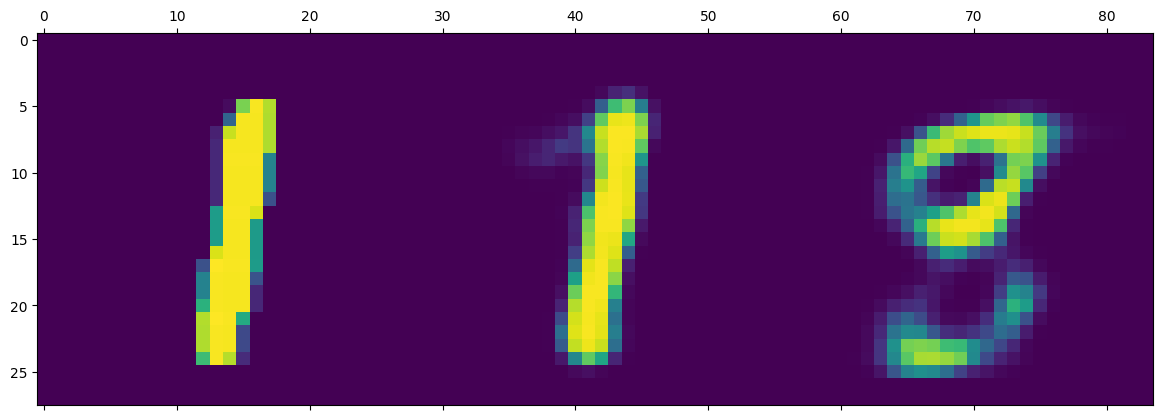

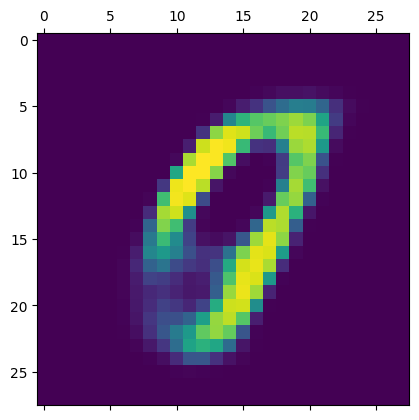

In [11]:
#测试
model.eval()
#每个epoch重置损失，设置进度条
test_loss = 0
test_nsample = 0
e = tqdm(test_loader,desc = f'[eval]epoch:{epoch}')
for imgs, label in e:
    bs = imgs.shape[0]
    #获取数据
    imgs = imgs.to(device).view(bs,input_size)
    #模型运算   
    re_imgs, mu, sigma = model(imgs)
    #计算损失
    loss_re = loss_BCE(re_imgs, imgs) 
    loss_norm = loss_KLD(mu, sigma) 
    loss = loss_re + loss_norm
    #计算平均损失，设置进度条
    test_loss += loss.item()
    test_nsample += bs
    e.set_postfix({'loss':test_loss/test_nsample})
#每个epoch记录总损失    
loss_history['eval'].append(test_loss/test_nsample)


#展示效果   
#按标准正态分布取样来自造数据
sample = torch.randn(1,latent_size).to(device)
#用decoder生成新数据
gen = model.decoder(sample)[0].view(28,28)
#将测试步骤中的真实数据、重构数据和上述生成的新数据绘图
concat = torch.cat((imgs[0].view(28, 28),
        re_imgs[0].view( 28, 28), gen), 1)
plt.matshow(concat.cpu().detach().numpy())
plt.show()

# #显示每个epoch的loss变化
# plt.plot(range(epoch+1),loss_history['train'])
# plt.plot(range(epoch+1),loss_history['eval'])
# plt.show()

'调用模型'
#按标准正态分布取样来自造数据
sample = torch.randn(1,latent_size).to(device)
#用decoder生成新数据
generate = model.decoder(sample)[0].view(28,28)
#展示生成数据
plt.matshow(generate.cpu().detach().numpy())
plt.show()